In [14]:
import torch
from torch.utils.data import DataLoader
import os
import pandas as pd
from work.utils.dataset import PandasDataset, RGB2HedTransform, RGB2HSVTransform, RGB2LABTransform, RGB2LUVTransform, RGB2XYZTransform
import matplotlib.pyplot as plt
from torch.utils.data.sampler import RandomSampler
import albumentations

In [15]:
output_dimensions = 5
data_dir = '../../../dataset'
images_dir = os.path.join(data_dir, 'tiles')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
df_test = pd.read_csv(f"../../data/test.csv")
backbone_model = 'efficientnet-b0'
pretrained_model = {
    backbone_model: '../pre-trained-models/efficientnet-b0-08094119.pth'
}

In [16]:
data = df_test[:1]

Based on the code, you want to make all transform entries in the `transforms` dictionary follow the same structure as the "HED" entry, which has a dictionary with "transform", "title", and "denormalize" fields.



In [34]:
from work.utils.dataset import RGB2YHVTransform, RGB2Fusion

transforms = {
    "HED": {
        "title": "HED",
        "denormalize": False,
        "dataset": PandasDataset(
            images_dir,
            data,
            transforms=albumentations.Compose([RGB2HedTransform()])
        )
    },
    "HSV": {
        "title": "HSV",
        "denormalize": False,
        "dataset": PandasDataset(
            images_dir,
            data,
            transforms=albumentations.Compose([RGB2HSVTransform()])
        )
    },
    "LAB": {
        "title": "LAB",
        "denormalize": False,
        "dataset": PandasDataset(
            images_dir,
            data,
            transforms=albumentations.Compose([RGB2LABTransform()])
        )
    },
    "LUV": {
        "title": "LUV",
        "denormalize": False,
        "dataset": PandasDataset(
            images_dir,
            data,
            transforms=albumentations.Compose([RGB2LUVTransform()])
        )
    },
    "XYZ": {
        "title": "XYZ",
        "denormalize": False,
        "dataset": PandasDataset(
            images_dir,
            data,
            transforms=albumentations.Compose([RGB2XYZTransform()])
        )
    },
    "RGB": {
        "title": "RGB",
        "denormalize": False,
        "dataset": PandasDataset(
            images_dir,
            data,
            transforms=albumentations.Compose([])
        )
    },
    "YHV": {
        "title": "YHV",
        "denormalize": False,
        "dataset": PandasDataset(
            images_dir,
            data,
            transforms=albumentations.Compose([RGB2YHVTransform()])
        )
    },
    "SUM": {
        "title": "Sum",
        "denormalize": False,
        "dataset": PandasDataset(
            images_dir,
            data,
            transforms=albumentations.Compose(
                [RGB2Fusion(space_colors=["rgb", "xyz", "lab"])]
            )
        )
    },
    "MEAN": {
        "title": "Mean",
        "denormalize": False,
        "dataset": PandasDataset(
            images_dir,
            data,
            transforms=albumentations.Compose(
                [RGB2Fusion(mode="mean", space_colors=["rgb", "xyz", "lab"])]
            )
        )
    },
    "MAX": {
        "title": "Max",
        "denormalize": False,
        "dataset": PandasDataset(
            images_dir,
            data,
            transforms=albumentations.Compose(
                [RGB2Fusion(mode="max", space_colors=["rgb", "xyz", "lab"])]
            )
        )
    }
}


In [35]:
def custom_denormalize(image_tensor, title):
    # image_tensor: torch.Tensor (C,H,W)
    image_np = image_tensor.cpu().numpy().transpose(1, 2, 0)  # (H,W,C)

    # Lógica de normalização específica para cada espaço de cor
    if title == "HED":
        # HED não tem um mapeamento RGB direto.
        # Vamos visualizar o canal de hematoxilina (o mais importante)
        # e normalizar seus valores
        h_channel = image_np[:, :, 0]
        h_channel = (h_channel - h_channel.min()) / (h_channel.max() - h_channel.min() + 1e-8)
        # Para exibir, podemos criar uma imagem em escala de cinza com este canal
        return np.stack([h_channel] * 3, axis=-1)

    elif title == "LAB" or title == "LUV":
        # LAB e LUV possuem canais com faixas de valores diferentes.
        # Normalização min-max canal por canal
        normalized_channels = []
        for i in range(image_np.shape[2]):
            channel = image_np[:, :, i]
            channel_norm = (channel - channel.min()) / (channel.max() - channel.min() + 1e-8)
            normalized_channels.append(channel_norm)
        return np.stack(normalized_channels, axis=-1)

    elif title == "HSV":
        # HSV é geralmente normalizado para [0,1]
        # O Matplotlib consegue exibir bem, mas garantimos o clip
        return np.clip(image_np, 0, 1)

    elif title == "XYZ":
        # XYZ também tem faixas de valores não-convencionais.
        # Normalizamos min-max canal por canal
        normalized_channels = []
        for i in range(image_np.shape[2]):
            channel = image_np[:, :, i]
            channel_norm = (channel - channel.min()) / (channel.max() - channel.min() + 1e-8)
            normalized_channels.append(channel_norm)
        return np.stack(normalized_channels, axis=-1)

    elif title == "RGB":
        # Para RGB, garantimos que a imagem esteja em [0,1]
        if image_np.max() > 1.0:
            return image_np / 255.0
        return image_np

    else:
        # Padrão para outros casos, apenas normalização min-max geral
        return (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8)


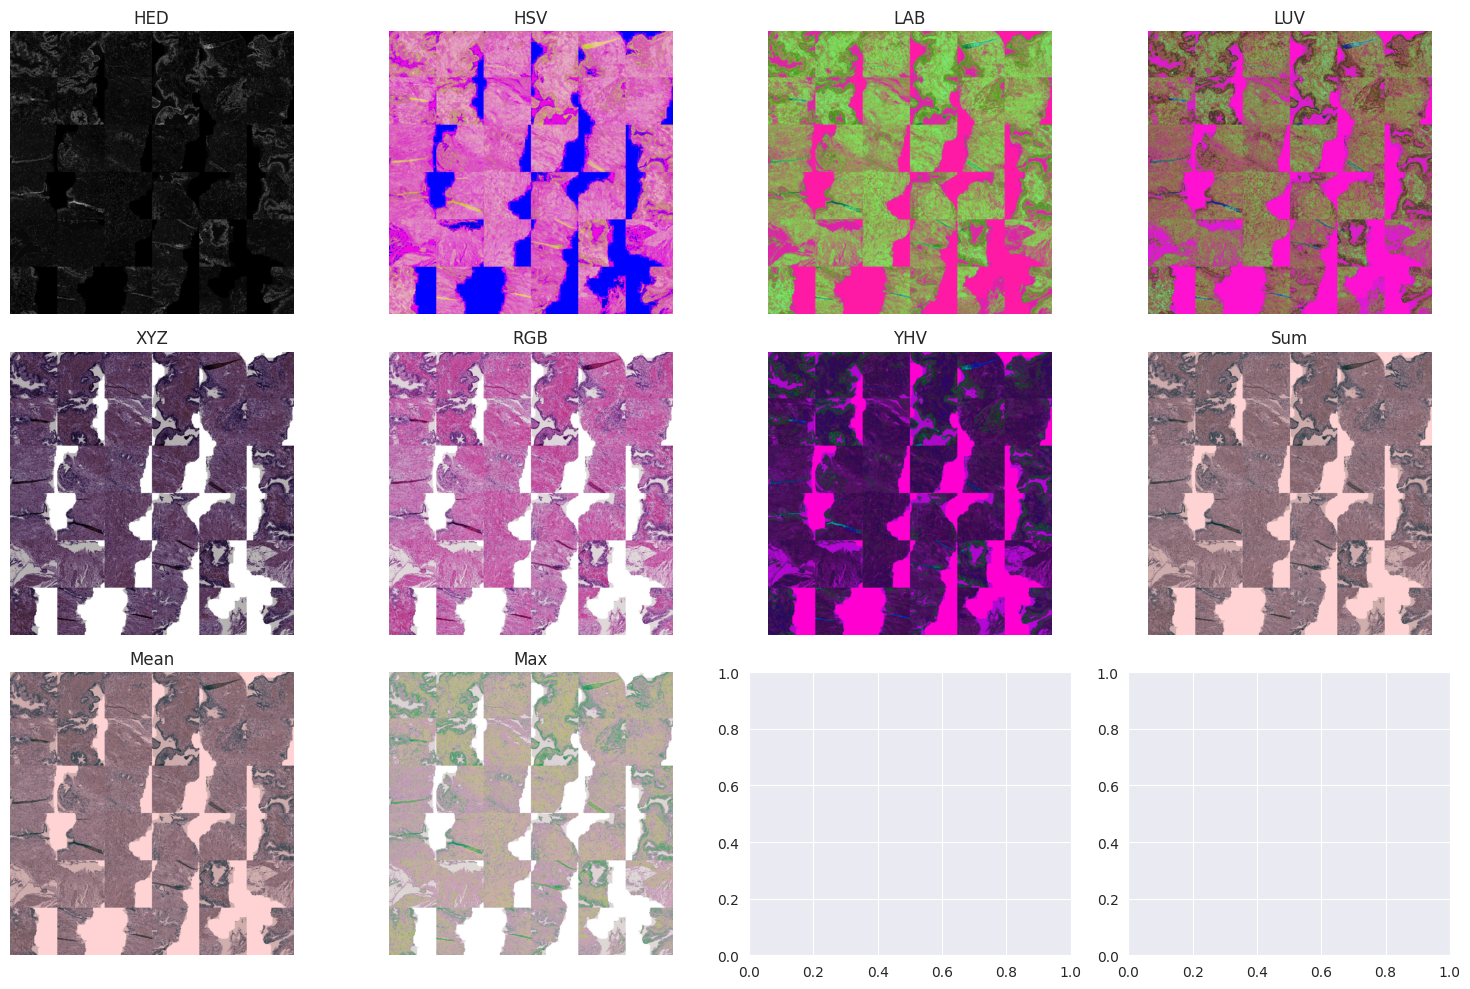

In [36]:
import numpy as np
import matplotlib.pyplot as plt
# Novo loop de plotagem
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()

for idx, (name, transform_dict) in enumerate(transforms.items()):
    dataloader = DataLoader(
        transform_dict["dataset"],
        batch_size=2,
        num_workers=2,
        sampler=RandomSampler(transform_dict["dataset"])
    )

    image_data = next(iter(dataloader))[0][0]  # tensor shape: (C, H, W)

    # Use a nova função de denormalização para todos os plots
    img = custom_denormalize(image_data, transform_dict["title"])

    # Garante que a imagem fique no intervalo [0,1] para matplotlib
    img = np.clip(img, 0, 1)

    # Para HED, LAB e LUV, que não são diretamente visualizáveis em RGB,
    # pode ser útil converter de volta para RGB para uma visualização mais
    # colorida. Por exemplo:
    # if name == "LAB":
    #     lab_to_rgb = color.lab2rgb(image_data.numpy().transpose(1, 2, 0))
    #     img = np.clip(lab_to_rgb, 0, 1)

    # Mas a normalização por canal já é um bom começo e representa
    # melhor o que o espaço de cor está fazendo.

    axes[idx].imshow(img)
    axes[idx].set_title(transform_dict["title"])
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig("image_by_color_improved.png", dpi=300)
plt.show()

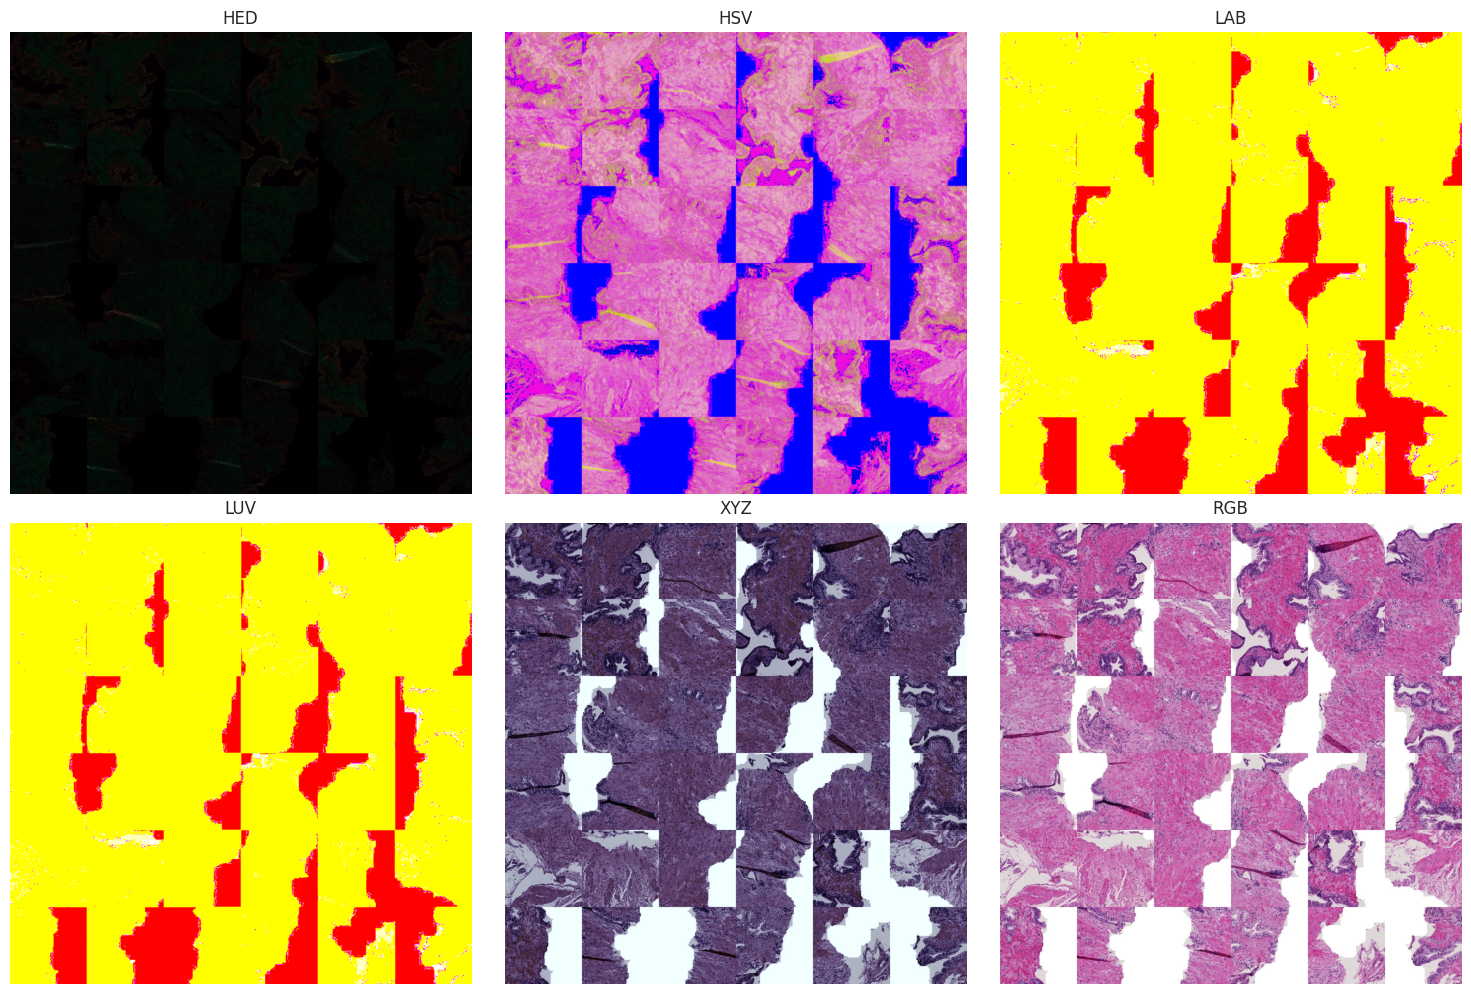

In [18]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, RandomSampler

for idx, (name, transform_dict) in enumerate(transforms.items()):
    dataloader = DataLoader(
        transform_dict["dataset"],
        batch_size=2,
        num_workers=2,
        sampler=RandomSampler(transform_dict["dataset"])
    )

    # Pega o primeiro batch, primeira imagem
    image_data = next(iter(dataloader))[0][0]  # tensor shape: (C, H, W)

    if idx == 0:
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

    def denormalize(image_tensor):
        # image_tensor: torch.Tensor (C,H,W)
        image_np = image_tensor.cpu().numpy()
        image_np = image_np.transpose(1, 2, 0)  # (H,W,C)
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8)
        return image_np

    if transform_dict["denormalize"]:
        img = denormalize(image_data)
    else:
        # Se não denormaliza, só passa para numpy e troca eixo
        img = image_data.cpu().numpy().transpose(1, 2, 0)

    # Ajuste especial para RGB que pode estar em 0-255 uint8 ou 0-1 float
    if transform_dict.get("title") == "RGB":
        # Se valores > 1, normaliza para 0-1
        if img.max() > 1.0:
            img = img / 255.0

    # Garante que imagem fique no intervalo [0,1] para matplotlib
    img = img.clip(0, 1)

    axes[idx].imshow(img)
    axes[idx].set_title(transform_dict["title"])
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig("image_by_color.png", dpi=300)
plt.show()